In [1]:
### note book exploring the advertorch library and it's attacks
# should be easier to use than others

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch_helper_lib as th
import torch

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device
torch.cuda.set_device(1)

CUDA Available:  True
Using device: cuda


In [5]:
# create fgn model or classic model to test

model_type = 'fgn'

hidden_layers = []
exp_num = 1
if model_type=='fgn':
    model = th.Feedforward_FGN_net(hidden_l_nums=hidden_layers, in_feats=28*28, out_feats=10)
    weights = "./saved_models/Converted_MNIST_Nets/fgn_model_{}_exp_{}_state_dict.pth".format(hidden_layers, exp_num)
    model.load_state_dict(torch.load(weights))
if model_type=='classic':
    model = th.Classic_MNIST_Net(hidden_l_nums=hidden_layers)
    weights = "./saved_models/Classic_MNIST_Nets/model_{}_exp_{}_state_dict.pth".format(hidden_layers, exp_num)
#     print("State Dict:", weights)
    model.load_state_dict(torch.load(weights))

model.to(device)
model.eval()

Feedforward_FGN_net(
  (hidden_layers): ModuleList()
  (fl): FGN_layer()
)

In [6]:
### load data sets
from advertorch_examples.utils import get_mnist_test_loader

batch_size = 5
loader = get_mnist_test_loader(batch_size=batch_size)
for cln_data, true_label in loader:
    break
cln_data, true_label = cln_data.to(device), true_label.to(device)

In [7]:
# MNIST dataset and dataloader declaration
# transforms does both the conversion from 0-255 to 0-1
# and normalizes by the precomputed mean and std
from torchvision import datasets, transforms

batch_size = 5

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../MNIST-dataset', train=True, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=False)

mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../MNIST-dataset', train=False, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=False)

for cln_data, true_label in mnist_train_loader:
    break
cln_data, true_label = cln_data.to(device), true_label.to(device)

In [8]:
# eval model
import torch.nn.functional as F
# nll loss function
def fgn_nll_loss_func(model, output, target):
#     # split output into pred and likelihoods
#     output, likelihood = output
    return F.nll_loss(output, target.long())    
# number of correct pred function for fgnet
def fgn_pred_func(output, target):
#     # split output into pred and likelihoods
#     output,_ = output
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct = pred.eq(target.long().view_as(pred)).sum().item()
    return correct

In [9]:
th.test(model=model, device=device, test_loader=mnist_test_loader, loss_func=fgn_nll_loss_func, pred_func=fgn_pred_func, verbose=2)

Test set - Average loss: 2.0695, Accuracy: 9189/10000 (92%)


{'test_accuracy': 91.89, 'test_loss': 2.06946982717514}

In [10]:
from advertorch.attacks import FGSM

adversary = FGSM(model)

In [11]:
adv_untargeted = adversary.perturb(cln_data, true_label)

In [12]:
target = torch.ones_like(true_label) * 3
adversary.targeted = True
adv_targeted = adversary.perturb(cln_data, target)

<IPython.core.display.Javascript object>


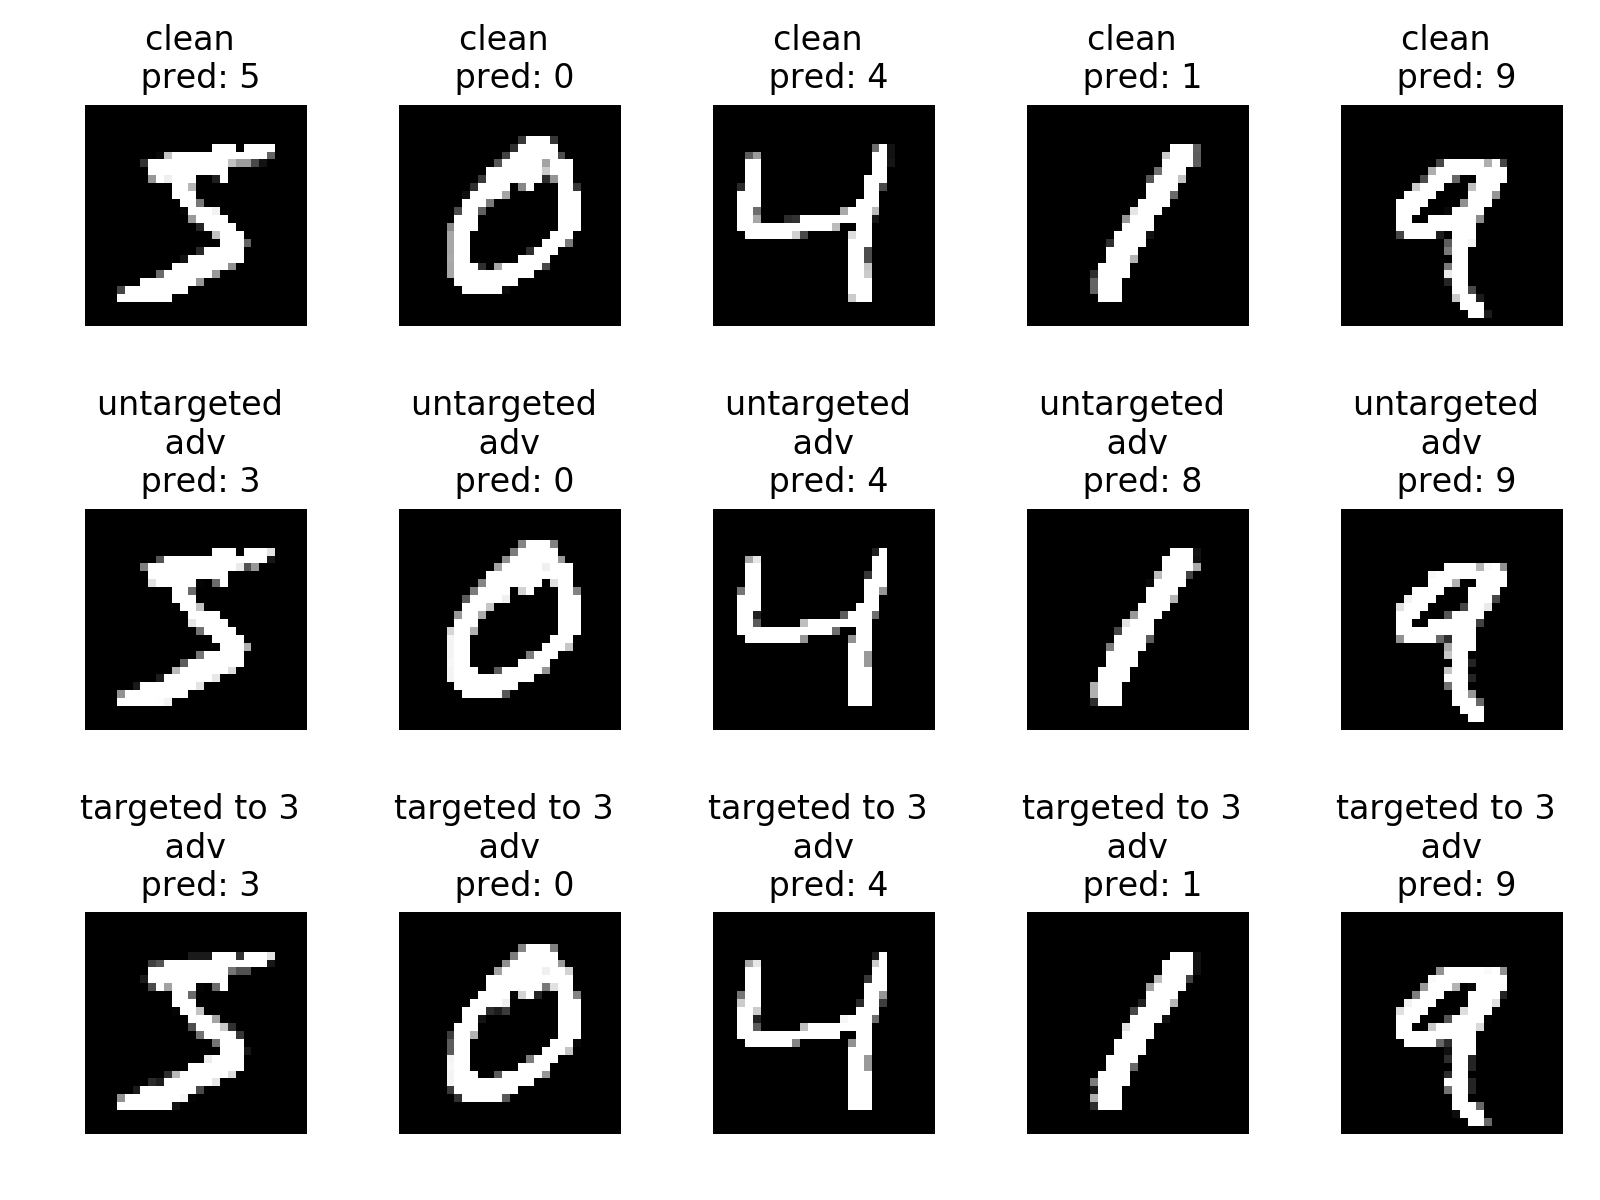

In [13]:
from advertorch.utils import predict_from_logits

pred_cln = predict_from_logits(model(cln_data))
pred_untargeted_adv = predict_from_logits(model(adv_untargeted))
pred_targeted_adv = predict_from_logits(model(adv_targeted))

from advertorch_examples.utils import _imshow

plt.figure(figsize=(8, 6))
for ii in range(batch_size):
    plt.subplot(3, batch_size, ii + 1)
    _imshow(cln_data[ii])
    plt.title("clean \n pred: {}".format(pred_cln[ii]))
    plt.subplot(3, batch_size, ii + 1 + batch_size)
    _imshow(adv_untargeted[ii])
    plt.title("untargeted \n adv \n pred: {}".format(
        pred_untargeted_adv[ii]))
    plt.subplot(3, batch_size, ii + 1 + batch_size * 2)
    _imshow(adv_targeted[ii])
    plt.title("targeted to 3 \n adv \n pred: {}".format(
        pred_targeted_adv[ii]))

plt.tight_layout()
plt.show()

In [14]:
model(adv_untargeted[3])

tensor([[-3.2731, -1.5661, -1.7600, -2.1629, -3.0365, -3.2327, -2.9646, -3.1358,
         -1.5000, -2.8032]], device='cuda:1', grad_fn=<LogSoftmaxBackward>)